In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Generate wavelength grid same as MMT

In [2]:
data_dir = "../../../DATA_MAY18/spec1d/"
fname270 = '2-8h30m-270-spec1d.npz'
fname600 = '2-8h30m-600-spec1d.npz'
data270 = np.load(data_dir + fname270)
data600 = np.load(data_dir + fname600)

In [3]:
def wave_grid(data):
    """Returns wavegrid based on header file from data"""
    
    crval1 = float(str(data['headers'][1]).split("CRVAL1")[1].split("=")[1].split("/")[0]) #Starting value
    cdelt1 = float(str(data['headers'][1]).split("CDELT1")[1].split("=")[1].split("/")[0]) #Pixel size
    
    collapsedSpectrum = data['data_ivar'][:, 0, :]
    
    wave_grid = crval1 + cdelt1 * np.arange(collapsedSpectrum[1].shape[0])
    wave_grid *= 10 #Convert wave_grid to Angstrom from nm
    return wave_grid

In [4]:
wg270 = wave_grid(data270)
wg600 = wave_grid(data600)

## Functions to generate mock 1d catalogues

In [5]:
def ModelGen(wg, z, width, Amp = 1, offset = 0, GaussianNoiseTrue = False):
    """Generates mock Gaussian filter model at redshift z with an optional offset
    
    Parameters
    ----------
    z: array of redshifts at which the model is being tested
    wg: pixel grid of the Window
    width: width array of the Gaussian doublets
    Amp: amplitude of the Gaussian doublets
    
    Returns
    --------
    model: Gaussian models in the range of [z - window_width, z + window_width]
    """
    
    lambda_r27 = 3727.092; lambda_r29 = 3729.875 #rest frame wavelength of the [OII] doublets
    separation_r = (lambda_r29 - lambda_r27) #separation between the emission lines in rest frame
    lambda0 = lambda_r27 + separation_r/2 #Midpoint of the gaussian emission lines in restframe
    lambda_obs = lambda0*(1 + z) #Observed wavelength of of the midpoint
    Gaussian = lambda x, mean, std: (1/np.sqrt(2*np.pi*std**2))*np.exp(-((x[:, np.newaxis] - mean)/std)**2)

    if(not GaussianNoiseTrue == True):
        model = (Amp/2*(Gaussian(wg, lambda_obs - separation_r, width) \
                    + Gaussian(wg, lambda_obs + separation_r, width))) + offset
        return model
    else:
        errstd = 0.001
        errarray = np.random.normal(0, errstd, wg.shape)[:, np.newaxis]
        model = (Amp/2*(Gaussian(wg, lambda_obs - separation_r, width) \
                    + Gaussian(wg, lambda_obs + separation_r, width))) \
             + offset + errarray
        return model, 1/errarray**2

In [6]:
def mockCatalogue(maskgrating, ngal = 1, seed = 100):
    """Generates 1d mock masks as MMT"""
    
    if(maskgrating == 270):
        zlow = 0.0; zhigh = 1.5
        wg = wg270
    elif(maskgrating == 600):
        zlow = 0.7; zhigh = 1.61
        wg = wg600
        
    widths = np.arange(0.1, 2, 0.05)
    
    models = np.zeros((ngal, len(wg)))
    ivars = np.zeros((ngal, len(wg)))
    zlist = np.zeros(ngal)
    wlist = np.zeros(ngal)
    offsetlist = np.zeros(ngal)
    
    np.random.seed(seed)
    for i in range(ngal):
        z = np.round(np.random.uniform(zlow, zhigh, 1), 3)
        w = np.round(np.random.uniform(0.1, 2., 1),2)
        offset = np.round(np.random.uniform(0.0, 2., 1),1)
        
        tmp1, tmp2 = ModelGen(z = z, width = w, wg = wg, offset = offset,\
                      GaussianNoiseTrue = True)
        
        models[i] = tmp1.reshape((len(tmp1),))
        ivars[i] = tmp2.reshape((len(tmp2),))
        zlist[i] = z
        wlist[i] = w
        offsetlist[i] = offset
        
    #injectionModels = np.vstack(zlist, wlist, offsetlist) #Injection model matrix is z, w, offset respectively
    #injectionModels = injectionModels.T #Transpose for readability
    
    #To make the data structure look same as Jae's .npz files
    tmp = np.dstack((models, ivars))
    tmp = np.transpose(tmp, (0,2,1))
    
    np.savez("mock1D_data", data_ivar=tmp)
    np.savez("mock1D_models", z=zlist, w=wlist, offset=offsetlist)

## Generate mock catalogue and load it

In [7]:
maskname = 270
mockCatalogue(maskname, ngal = 143)

In [8]:
data = np.load("mock1D_data.npz")
injectionModels = np.load("mock1D_models.npz")

## Analysis

In [9]:
def lambda_to_z(wavelength):
    """Converts wavelength grid to redshift grid"""
    
    separation = (3729.875-3727.092)/2 #separation between the emission lines
    lambda0 = 3727.092 + separation #Midpoint of the gaussian emission lines in restframe
    
    return (wavelength/lambda0 - 1)

In [10]:
def Window(z, wg, z_grid, window_width = 0.005):
    """Returns a range of pixel in the specified window width
    
    Parameters
    ----------
    z: Centre of the window
    wg: wave grid that needs to be windowed
    z_grid: redshift grid of the wave_grid
    window_width: size of the window in redshift space
    
    Returns
    -------
    windowed_array: windowed array of the windowing_array    
    """
    windowed_array = wg[(z_grid > (z - window_width)) & (z_grid < (z + window_width))]
    
    return windowed_array

In [11]:
def Model(z, wg2, width, Amp = 1):
    """Returns Gaussian filter model at redshift z
    
    Parameters
    ----------
    z: array of redshifts at which the model is being tested
    wg2: pixel grid of the Window
    width: width array of the Gaussian doublets
    Amp: amplitude of the Gaussian doublets
    
    Returns
    --------
    model: Gaussian models in the range of [z - window_width, z + window_width]
    """
    
    lambda_r27 = 3727.092; lambda_r29 = 3729.875 #rest frame wavelength of the [OII] doublets
    separation_r = (lambda_r29 - lambda_r27) #separation between the emission lines in rest frame
    lambda0 = lambda_r27 + separation_r/2 #Midpoint of the gaussian emission lines in restframe
    lambda_obs = lambda0*(1 + z) #Observed wavelength of of the midpoint
    Gaussian = lambda x, mean, std: (1/np.sqrt(2*np.pi*std**2))*np.exp(-((x[:, np.newaxis] - mean)/std)**2)

    model = Amp/2*(Gaussian(wg2, lambda_obs - separation_r, width) + Gaussian(wg2, lambda_obs + separation_r, width))
        
    return model

In [12]:
def SNR_calculator(maskname, data):
    """maskname[-3:] yields the grating number. z_range changes depending
    on maskname because of variation in grating. The start and end points
    are chosen by inspecting the header file of the data."""
    
    if(maskname[-3:] == '270'):
        z_range = np.arange(0.677, 1.5, 0.001)
    elif(maskname[-3:] == '600'):
        z_range = np.arange(0.7, 1.6, 0.001)
    widths = np.arange(.5, 1., .1)
    
    #Read data
    image = data['data_ivar'][:, 0, :]
    ivar = data['data_ivar'][:, 1, :]
    wg = wave_grid(data270)
    z_grid = lambda_to_z(wg) #Convert wavelength space to redshift space
    
    results = np.zeros((z_range.size, image.shape[0], widths.size))
    Amps = np.zeros((z_range.size, image.shape[0], widths.size))
    
    for i, z in enumerate(z_range):
        wg2 = Window(z, wg, z_grid)
        
        model = Model(z, wg2, widths)
        #print('model ' + str(model.shape))
        #Find the idx of the edges of the windows and slice the image file to multiply with modelPrime
        minidx = np.where(wg == np.min(wg2))[0][0] 
        maxidx = np.where(wg == np.max(wg2))[0][0]
        imageSliced = image[:,minidx:maxidx+1]
        #print('image sliced ' + str(imageSliced.shape))
        imageSliced = imageSliced[:, :, np.newaxis] #Broadcasting
        #print('image sliced broadcasted ' + str(imageSliced.shape))
        ivarSliced = ivar[:,minidx:maxidx+1]
        ivarSliced = ivarSliced[:, :, np.newaxis] #Broadcasting
        imagePrimeSliced = imageSliced*np.sqrt(ivarSliced)
        #print('image prime sliced ' + str(imagePrimeSliced.shape))
        Mprime = np.sqrt(ivarSliced)*model
        #print('Mprime ' + str(Mprime.shape))
        Denominator = Mprime**2
        #print('Denom' + str(Denominator.shape))
        Denominator = np.sum(Denominator, axis = 1)
        #print('Denom' + str(Denominator.shape))
        Numerator = Mprime*imagePrimeSliced
        #print('Nume' + str(Numerator.shape))
        Numerator = np.sum(Numerator, axis = 1)
        #print('Nume' + str(Numerator.shape))
        """
        sigmaA^(-2) = M'.M'
        A = (D'.M')/(M'.M') => (D'.M')*(sigmaA^(2))
        """
        
        Amp = Numerator/Denominator
        sigmaA = np.sqrt(1./Denominator)
        SNR = Amp/sigmaA
        
        results[i] = SNR
        Amps[i] = Amp

    results = results.transpose([1, 2, 0]) #This maintains the indices
    Amps = Amps.transpose([1, 2, 0])
    
    return z_range, widths, results, Amps

In [13]:
from time import time

start = time()
z, widths, SNR_tmp, Amps_tmp = SNR_calculator('2-8h30m-270', data)
end = time()

tot_time = end - start
print(str(tot_time))

1.1532235145568848


## 1D spectra and error

Text(0.5,1,'1D inverse variance')

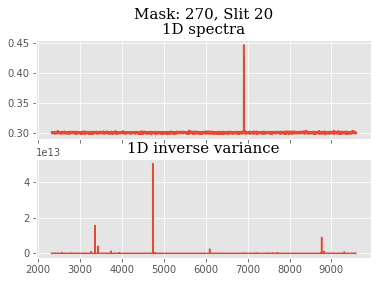

In [14]:
idx = 20

image = data['data_ivar'][:, 0, :]
ivar = data['data_ivar'][:, 1, :]

imagetmp = image[idx, :]
ivartmp = ivar[idx, :]

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(wave_grid(data270), imagetmp)
axarr[0].set_title('Mask: ' + str(maskname) + ', ' + 'Slit ' + str(idx) + "\n" + "1D spectra" \
                   ,  fontsize = 15, fontname = 'serif')
axarr[1].plot(wave_grid(data270), ivartmp)
axarr[1].set_title('1D inverse variance', fontsize = 15, fontname = 'serif')
#plt.savefig('results/spectra1d/' + maskname + '-' + str(idx) + '-spectra1d.pdf', dpi = 600, bbox_inches = None)

### SNR(w, z)

(5, 823)


Text(0.5,1,'Mask: 270, Slit 20')

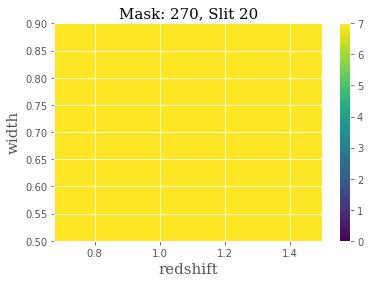

In [15]:
print(SNR_tmp[idx].shape)
plt.imshow(SNR_tmp[idx], aspect='auto', interpolation='None', \
           extent=[np.min(z), np.max(z), np.min(widths), np.max(widths)], vmin=0, vmax=7)
plt.colorbar()
plt.ylabel('width', fontsize = 15, fontname = 'serif')
plt.xlabel('redshift', fontsize = 15, fontname = 'serif')
plt.title('Mask: ' + str(maskname) + ', ' + 'Slit ' + str(idx),  fontsize = 15, fontname = 'serif')
#plt.savefig("results/SNR2D/" + maskname + '-' + str(idx) + "-SNR2d.pdf", dpi = 600, bbox_inches = None)

### Max z and w

In [16]:
print("Max SNR for slit " + str(idx) + " is " + str(np.nanmax(SNR_tmp[idx])))

"""nanargmax flattens SNR_tmp[idx] and finds the index number of the max value while ignorning NaNs.
Then passing that index to unravel_index helps find the coordinate location of the max in the original
matrix shape. The second argument is the shape of the matrix. Thus for a given index and a given matrix
shape, unravel_index can unflatten the 1D data and reshape it to the desired matrix shape and then 
find out the coordinate of the desired value."""

w, redshift = np.unravel_index(np.nanargmax(SNR_tmp[idx]), np.array(SNR_tmp[idx]).shape)
print("Maximum SNR has -- width: " + str(widths[w]) + ' and redshift: ' + str(z[redshift]))


#Corresponding wavelength
lambda_r27 = 3727.092; lambda_r29 = 3729.875 #rest frame wavelength of the [OII] doublets
separation_r = (lambda_r29 - lambda_r27) #separation between the emission lines in rest frame
lambda0 = lambda_r27 + separation_r/2 #Midpoint of the gaussian emission lines in restframe
print("Wavelength corresponds to: " + str(lambda0*(1+z[redshift])))
print(lambda0)

Max SNR for slit 20 is 897718.8064355294
Maximum SNR has -- width: 0.8999999999999999 and redshift: 1.3520000000000008
Wavelength corresponds to: 8769.393192000003
3728.4835000000003


Text(0.5,1,'Mask: 270, Slit 20\nz = 1.352, w = 0.9')

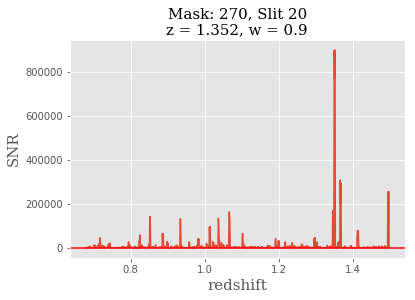

In [17]:
plt.plot(z, SNR_tmp[idx, w])
plt.axhline(7, c = 'red')
plt.ylabel('SNR', fontsize = 15, fontname = 'serif')
plt.xlabel('redshift', fontsize = 15, fontname = 'serif')
plt.title('Mask: ' + str(maskname) + ', ' + 'Slit ' + str(idx) +"\n" +\
          "z = " + str(np.round(z[redshift], 3)) + ', w = ' + str(np.round(widths[w],2)) \
          , fontsize = 15, fontname = 'serif')
#plt.xlim([z[redshift] - .1, z[redshift] + .1])
#plt.savefig("results/SNRvsRedshift/" + maskname + '-' + str(idx) + "-SNR_vs_z.pdf", dpi = 600, bbox_inches = None)

### Zooming into 1D spectra around wavelength range with the peak

In [18]:
wg1 = wave_grid(data270)
z_grid = lambda_to_z(wg1)
wg3 = wg1[(wg1 > (1+z[redshift])*(3728.4835-20.)) & (wg1 < (1+z[redshift])*(3728.4835+20.))]

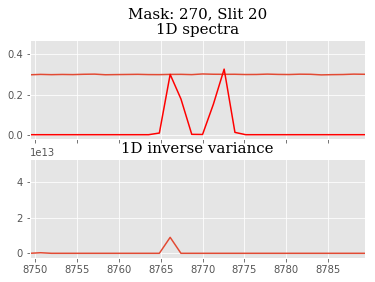

In [19]:
ranges = 20

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(wave_grid(data270), imagetmp)
axarr[0].set_title('Mask: ' + str(maskname) + ', ' + 'Slit ' + str(idx) + "\n" + "1D spectra" \
                   ,  fontsize = 15, fontname = 'serif')
axarr[1].plot(wave_grid(data270), ivartmp)
axarr[1].set_title('1D inverse variance', fontsize = 15, fontname = 'serif')
axarr[0].set_xlim([lambda0*(1+z[redshift])-ranges, lambda0*(1+z[redshift])+ranges])
axarr[1].set_xlim([lambda0*(1+z[redshift])-ranges, lambda0*(1+z[redshift])+ranges])

axarr[0].plot(wg3, Model(z[redshift], wg3, widths[w], Amp=Amps_tmp[idx, w, redshift]), c = 'red')

#plt.savefig("results/PeakZoom/" + maskname + '-' + str(idx) + "-zoom1d.pdf", dpi = 600, bbox_inches = None)

In [20]:
print(injectionModels['z'][idx])
print(injectionModels['w'][idx])

0.853
1.33


In [21]:
key = input('Grating number: ')

Grating number: 600


In [24]:
key[-3:]

'600'